# 1. Preliminaries
## 1.1. Course Reminders: Models, Regression, Classification
 A (machine learning) model is essentially a mapping (a mathematical function $f$) between inputs $x$ and outputs $y$, such that $ y \approx f(x)$. For instance, in age estimation, the input data $x$ is the set of pixel values of a person's photo, and the output is the number $y$ corresponding to the age of that person.

<center><a href="https://pyimagesearch.com/2020/04/13/opencv-age-detection-with-deep-learning/">
    <img src="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2020/04/opencv_age_detection_examples.jpg?lossy=1&strip=1&webp=1" width="550"></a></center>
    
To perform such a task, we have to:

- Design a model $f$, that is, we specify a parameterized family of functions (e.g., a neural network). The number of parameters may range from a few to billions.
- Train $f$ using a dataset of known image/age pairs (a *training dataset*) in order to adjust the parameters of the model. We do that by considering an *optimization* problem: ideally, we want the predicted age $y_{\text{pred}} = f(x)$ to be as close as possible to the true age $y$. Therefore, we define a *loss function* which measures the difference between $y$ and $y_{\text{pred}}$, and we want to adjust the parameters of the model $f$ such that they minimize this loss function. This is achieved by using an optimization algorithm such as stochastic gradient descent, which is directly implemented in Pytorch.

Once the model is designed and trained, we can use it for performing predictions on novel data.

Broadly speaking, there are two types of tasks in supervised machine learning, depending on the nature of the output $y$:
- if $y$ can take only a finite number of values (usually represented as integers), then it is a *classification* task. The most basic case is when there are only two possible classes (binary classification or *detection*). Examples are hate speech detection (1 = hate, 0 = no hate), recommender systems (1 = like, 0 = dislike), spam detection (1 = spam, 0 = not spam), etc.
- if $y$ ranges in a continuous (and therefore infinite) set of values, then it is a *regression* task. Examples are age prediction as above ($y \in [0, 100]$, or any arbitrary high value), estimating the price of a product, weather forecast, etc.

In this lab, we will briefly experiment with the Autograd module of Pytorch (**Section 2**), and then use it for both regression (**Section 3**) and classification (**Section 4**) using neural networks. But first, let's set up our Python kernel (**Section 1.2**).

## 1.2. Setting-up the kernel
Please select a python kernel where pytorch and matplotlib are installed to run this notebook. If you don't have such an environment available, here is how to easily create and select one in Visual Studio Code:
- Click _Select Kernel_ on the upper-right corner of this window or _Select Another Kernel_
- Click _Python Environments..._
- Click _+Create Python Environment_
- Click _venv Manages virtual environments created using 'venv'_
- Select a Python version installed on your computer
- Choose a name for your environment (eg: assa25)
- Skip package installation
- Open a Terminal via the menu: Terminal -> New Terminal. The newly created environment should be activated in this terminal. If not, run the activation script in your newly created venv folder via: `source <envname>/bin/activate`
- Install pytorch via `pip install torch` and matplotlib via `pip install matplotlib`.
- To let your Jupyter notebook communicate back-and-forth with your python environment using the Jupyter messaging protocol, you will also need to install _ipykernel_ in it: `pip install ipykernel`
- That's it ! You should be able to run the cell below.

_Note: VSCode creates the venv folder in your project folder by default, which is ok for this tutorial. For more advanced or professional workflows, it is considered better practice to place all the venv folders in a centralized location, and to choose the most appropriate one from there._

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 2. Automatic differentiation (Autograd)

Autograd is the Pytorch engine that performs gradient tracking and computation. It really is the core of neural networks training, since optimization algorithms like stochastic gradient descent rely on gradient computation. Every tensor in Pytorch not only contains some values (the data itself), but also stores the gradients related to operations that have been computed using these tensors.

In [2]:
# By default, when tensors are created their gradients is not tracked
x = torch.ones(1, 10)
print(x.requires_grad)

False


In [3]:
# You can change it using the requires_grad_() method
x.requires_grad_()
print(x.requires_grad)

# Alternatively, when creating a tensor, you can directly set 'requires_grad=True'
x = torch.ones(1, 10, requires_grad=True)
print(x.requires_grad)

True
True


In [4]:
# You can access the gradient stored in x with 'x.grad'.
# However, since no computation has been performed yet, it should return 'None'
print(x.grad)

None


In [5]:
# If you create a tensor y from x using any torch operation, it will have a gradient function (grad_fn) which is specific to this operation
y = x + 50
print(y.grad_fn)

y = 3 * x
print(y.grad_fn)

y = x.mean()
print(y.grad_fn)

As an example, let's define an operation involving a 1D data tensor $\mathbf{x} = [x_0, \ldots, x_{9}]$ and a parameter $a$:

$$ loss = a \times \sum_i x_i. $$

We can mathematically compute the gradient of $loss$ with respect to $a$ and $\mathbf{x}$:

$$ \nabla_{a} loss = \sum_i x_i $$
and
$$  \nabla_{x_i} loss = a \quad (\text{or in vector form:} \quad \nabla_{\mathbf{x}} loss = [a, \ldots, a]). $$

Of course, on this example it would be easy to compute gradients by hand. But when working with deep neural networks with millions of parameters, this is impractical. The good news is that Pytorch does it automatically for us, thanks to the `backward()` method.

In [6]:
# Let's implement the above:
a = torch.tensor([3], requires_grad=True, dtype=torch.float) # specify float as the data type, otherwise it can't compute gradients
x = torch.ones(1, 10, requires_grad=True)

loss = x.sum() * a
print(loss.requires_grad)

# Now, let's compute the gradient of the loss with respect to x and a
loss.backward()

# These gradients are stored in x.grad and a.grad
print(x.grad)
print(a.grad)

True
tensor([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])
tensor([10.])


**Note**: When we create a Pytorch model using `torch.nn` modules (we'll see that later on), the corresponding parameters have `requires_grad=True` by default. It makes sense since these parameters are exactly what we want to optimize (therefore we need to compute their gradients). However, in general we do not need to compute the gradient with respect to the data (input $x$ and/or output $y$), since these are fixed. In the example above, we computed the gradient with respect to `x` purely for illustrative purpose.

In [7]:
# After a model is trained, we no longer need to compute its gradient. Therefore, when doing prediction,
# we can disable gradient tracking to save memory and computational time

with torch.no_grad():
    loss = x.sum() * a
    print(loss.requires_grad)

False


In [ ]:
# TODO:
# - define a data tensors x which simply contains the value 2
# - define another data tensor y which simply contains the value 10
# - define parameter tensors w and b with values 1 and 3, respectively (these need gradient tracking)
# - compute the loss as: loss=(y - (w*x + b))^2
# - compute the gradients of the loss
# - print the value of the gradient of loss with respect to w and b
# hint: to be sure there's no mistake, you can check if it's correct with a bit of math.

x = torch.tensor(2, dtype=torch.float)
y = torch.tensor(10, dtype=torch.float)
w = torch.tensor(1, requires_grad=True, dtype=torch.float)
b = torch.tensor(3, requires_grad=True, dtype=torch.float)

loss = (y-w*x-b) ** 2
loss.backward()

print(w.grad)
print(b.grad)

tensor(-20.)
tensor(-10.)


# 3. Regression
## 3.1. Linear regression

<center><a href="https://kpu.pressbooks.pub/learningstatistics/chapter/linear-regression/">
    <img src="https://kpu.pressbooks.pub/app/uploads/sites/66/2019/09/regression1a-1.png" width="500"></a></center>

Let's now address linear regression. Assuming we have several points of data pairs $(x,y)\in\mathbb{R}^2$, the model is simply $f(x) = wx + b$, where $w$ is called *weight* (or slope) and $b$ is called the *bias*. The goal of linear regression is to estimate the optimal $w$ and $b$ from the available training data $x$ and $y$.

**Note**: we don't really need Pytorch for solving that problem (indeed, a basic gradient descent algorithm can be implemented directly without too much hassle - if you have some math background and want to have fun, please feel free). Nonetheless, we consider it anyway because it is a good basic exercice, and once linear regression is solved, we can move to more sophisticated nonlinear regression and to (deep) neural networks.

### 3.1.1. Data

torch.Size([15, 1]) torch.Size([15, 1])


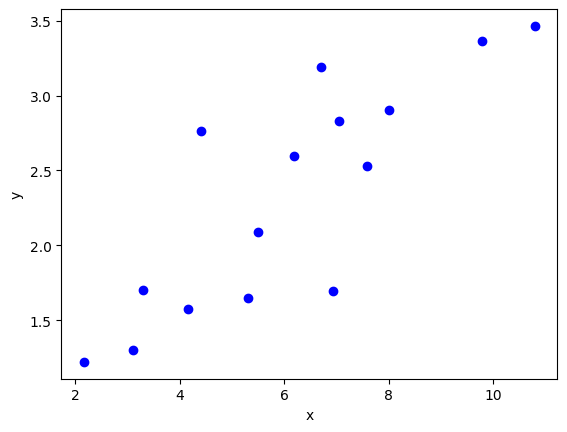

In [8]:
# Create a toy dataset
x = torch.tensor([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168], [9.779], [6.182], [7.59],
                 [2.167], [7.042], [10.791], [5.313], [7.997], [3.1]], dtype=torch.float)
y = torch.tensor([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573], [3.366], [2.596], [2.53],
                 [1.221], [2.827], [3.465], [1.65], [2.904], [1.3]], dtype=torch.float)
print(x.shape, y.shape)

# Plot the data (y as a function of x)
plt.figure()
plt.plot(x, y, 'bo')
plt.xlabel('x'), plt.ylabel('y')
plt.show()

**Note**: the data tensors `x` and `y` we have defined here constitute our *dataset*. Each data sample $(x,y)$ is actually one element in `(x,y)`. Therefore, we have one dataset of length 15, where each element ($x$ or $y$) has dimension 1. In other words, our dataset only consists of 1 batch, and the batch size is 15.

### 3.1.2. Linear Model

Let us create our linear model. In pytorch, it is easily done with `nn.Linear` (check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=torch%20nn%20linear#torch.nn.Linear)!). In particular, we need to specify the input and output sizes. In our case, these are equal to 1 since we work with scalars. There is also an option `bias` which can be `True` (default) or `False`. If `bias=False`, then $b=0$ and the model reduces to $f(x) = wx$.

In [9]:
# Create the linear model
input_size = 1
output_size = 1
lin_reg_model = nn.Linear(input_size, output_size, bias=True)

# 'lin_reg_model' is a module which contains the linear function and its parameters (weight and bias)
# When we instanciate the model, the parameters are initialized with random values
# We also remark that both parameters have 'requires_grad=True', which is the normal default behavior.
print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[-0.8504]], requires_grad=True)
Parameter containing:
tensor([-0.0501], requires_grad=True)


True
False


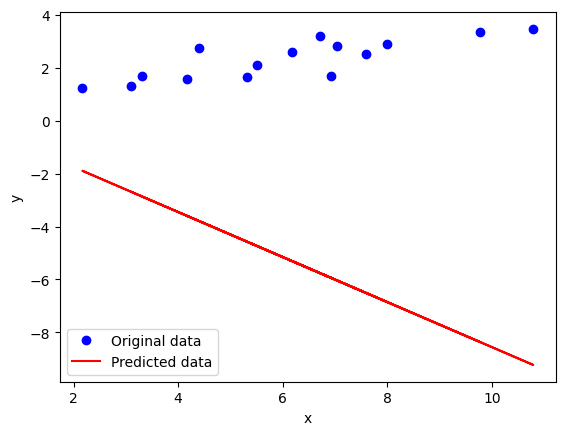

In [10]:
# Now we can compute predictions as y_pred = f(x) simply as follows:
y_pred = lin_reg_model(x)

# Since y_pred is computed from the model (which has requires_grad=True), then it also has requires_grad=True
print(y_pred.requires_grad)

# If we want to plot y_pred, we first need to get rid of its gradient (because by default it's tracked).
# This is done as follows:
y_pred = y_pred.detach()
print(y_pred.requires_grad)

# We can plot the predicted values on top of the original data
plt.figure()
plt.plot(x, y, 'bo', label='Original data')
plt.plot(x, y_pred, 'r', label='Predicted data')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

In [11]:
# It is possible to manually change the values of the parameters (weight and bias):
lin_reg_model.weight.data.fill_(2)
lin_reg_model.bias.data.fill_(3)

print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[2.]], requires_grad=True)
Parameter containing:
tensor([3.], requires_grad=True)


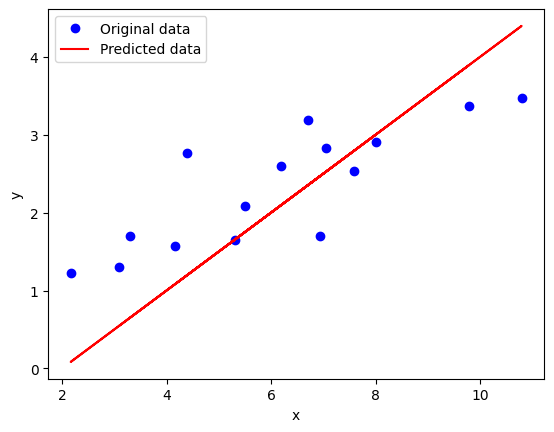

In [ ]:
# TODO:
# - set the weight and bias of the linear model at 0.5 and -1, respectively.
# - compute the new predictions y_pred with this model
# - plot the predictions on top of the original data

lin_reg_model.weight.data.fill_(0.5)
lin_reg_model.bias.data.fill_(-1)
y_pred = lin_reg_model(x)
y_pred = y_pred.detach()

plt.figure()
plt.plot(x, y, 'bo', label='Original data')
plt.plot(x, y_pred, 'r', label='Predicted data')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

### 3.1.3. Training

Now that our model is defined, we have to train it, that is, to optimize the values of $a$ and $b$. To do that, we first define the [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and the optimizer (i.e., [the optimization algorithm](https://pytorch.org/docs/stable/optim.html#algorithms)).

In [13]:
# TO DO: first, re-instanciate the model and set both the weight and bias at 1.
# This will avoid random values and ensure reproducibility (everyone should get the same results)
input_size = 1
output_size = 1
lin_reg_model = nn.Linear(input_size, output_size, bias=True)
with torch.no_grad():
    lin_reg_model.weight.copy_(torch.tensor([1]))
    lin_reg_model.bias.copy_(torch.tensor([1]))

In [15]:
# For linear regression, it is common to use the mean squared error (MSE) as loss function
loss_fn = nn.MSELoss() 

# For the optimizer, let's use stochastic gradient (SGD). In Pytorch, we need to specify:
# - which parameters are going to be updated (in this case, it's the parameters of our model)
# - the learning rate
optimizer = torch.optim.SGD(lin_reg_model.parameters(), lr=0.01)

Let us illustrate what happens when the loss function is noted $\mathcal{L}$ and the optimization algorithm is (stochastic) gradient descent (with a parameter $\mu$ called *learning rate*). The process of *training* is an iterative procedure, where at each iteration (or *epoch*), we perform the following operations:
1. Using the current model's parameters, compute the predictions: $y_{\text{pred}} = f(x)$
2. Using the loss function, compute the error between true values and predictions: $l = \mathcal{L}(y_{\text{pred}},y)$
3. Compute the gradients of the loss with respect to the parameters. If there are only two parameters $w$ and $b$, then we have to compute $\nabla_{w} l$ and $\nabla_{b} l$.
4. Perform gradient descent, that is, update the parameters with: $w \leftarrow w - \mu \nabla_{w} l$ and $b \leftarrow b - \mu \nabla_{b} l$

The good news is that we don't have to explicitly code steps 3. and 4., since Pytorch takes care about that for us with simple functions: all gradients are computed with `l.backward()` (we have seen this one already) and the gradient descent is simply performed with `optimizer.step()`.

**Note**: before computing the gradients with `l.backward()`, it's safer to remove all possible gradients that have been computed beforehand (e.g., from another model, or loaded in the memory) to avoid issues. This is easily done with: `optimizer.zero_grad()`.

In [ ]:
# TODO: Write the training loop for 10 epochs.
# At the end of each epoch, print the value of the loss (it is easily accessed with 'l.item()')

num_epochs = 10
for epoch in range(num_epochs):

    # Forward pass: calculate the predicted value with the model
    y_pred = lin_reg_model(x)
    
    # Compute the error between the true values y and the predicted values
    l = loss_fn(y, y_pred)

    # Compute the gradient of the loss with respect to the model parameters
    optimizer.zero_grad()
    l.backward()
    
    # Apply the gradient descent algorithm
    optimizer.step()
    
    # Print the average loss
    loss_current_epoch = l.item()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))

Epoch [1/10], Loss: 25.6761
Epoch [2/10], Loss: 0.6436
Epoch [3/10], Loss: 0.1803
Epoch [4/10], Loss: 0.1717
Epoch [5/10], Loss: 0.1715
Epoch [6/10], Loss: 0.1715
Epoch [7/10], Loss: 0.1715
Epoch [8/10], Loss: 0.1715
Epoch [9/10], Loss: 0.1715
Epoch [10/10], Loss: 0.1715


In [19]:
# After training, save the parameters of the trained model and display them
torch.save(lin_reg_model.state_dict(), 'model_linear_regression.pt')
print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[0.2400]], requires_grad=True)
Parameter containing:
tensor([0.8871], requires_grad=True)


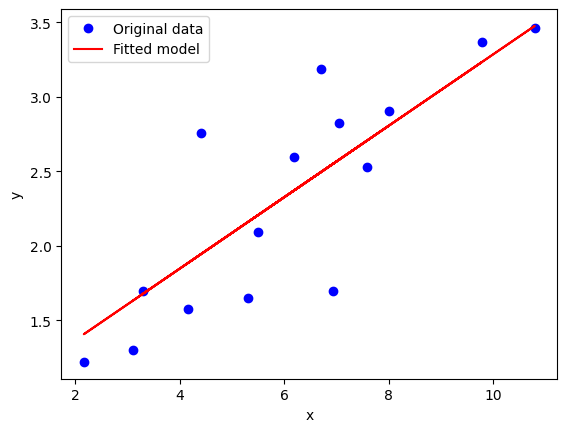

In [ ]:
# TODO: Compute the final estimates y_pred with the trained model, and display the results (predictions and original)
y_pred = lin_reg_model(x).detach()

plt.figure()
plt.plot(x, y, 'bo', label='Original data')
plt.plot(x, y_pred, 'r', label='Fitted model')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

## 3.2. Nonlinear regression

Let us now consider a more elaborate nonlinear regression model, for which we design our first neural network. In nonlinear regression, $f$ is no longer a simple linear/affine function, but something more complicated, or something that we don't really know.

<center><a href="https://www.r-bloggers.com/2016/02/first-steps-with-non-linear-regression-in-r/">
    <img src="https://i0.wp.com/datascienceplus.com/wp-content/uploads/2016/02/NLS_2.png" width="400"></a></center>

### 3.2.1. Nonlinear Data

We now consider sinusoidal-like data.

torch.Size([60, 1])


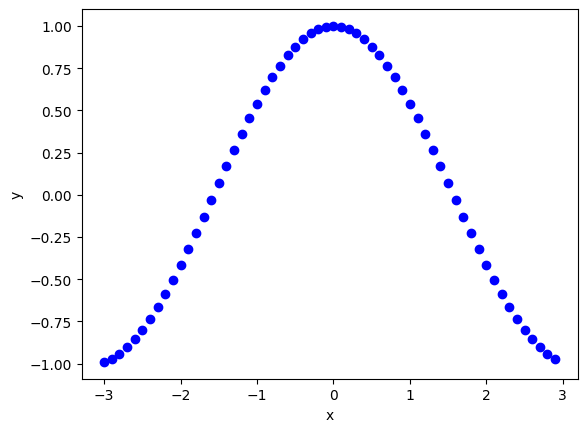

In [21]:
# TODO: generate sinusoidal data:
# - create a tensor x which ranges from -3 to 3 with a step of 0.1
# - Use unsqueeze(1) on x to add an extra dimension (its shape should be [60, 1])
# - compute y = cos(x)
# - plot y as a function of x

x = torch.arange(-3, 3, 0.1).unsqueeze(1)
print(x.shape)

y = torch.cos(x)

plt.figure()
plt.plot(x, y, 'bo')
plt.xlabel('x'), plt.ylabel('y')
plt.show()

### 3.2.2. Model : the simple perceptron

A basic idea behind neural networks is to assemble simple layers to approximate a potentially complicated function. For instance, in multilayer perceptrons (MLP), a network is designed by concatenating several layers, where each layer consists of:
- a linear function
- a non-linear element-wise activation function

There is a plethora of nonlinear activation function, which you can check [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). A popular one is the rectified linear unit ([ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)).

Here, we propose to approximate our sinusoidal data with a simple network made up with 2 linear layers and 1 activation function in between, i.e., a *simple perceptron*:

$$x \to \textrm{Linear}_1 \to \textrm{ReLU} \to \textrm{Linear}_2 \to y$$


In [23]:
# TODO: write the 'nonlin_reg_model' model.
# - the first linear layer should have input_size=1 and output_size=3 (we increase the dimension of x)
# - the second linear layer should have input_size=3 and output_size=1 (we go back to the dimension y)
# - to build the complete model, you can stack the separate layers together into one model using torch.nn.Sequential (check the doc!)
# - once it's done, compute nonlin_reg_model(x) to be sure there are no bugs

lin_layer1 = torch.nn.Linear(1, 3)
lin_layer2 = torch.nn.Linear(3, 1)
act_fn = torch.nn.ReLU()
nonlin_reg_model = torch.nn.Sequential(lin_layer1, act_fn, lin_layer2)

print(nonlin_reg_model(x))

tensor([[0.0125],
        [0.0167],
        [0.0210],
        [0.0252],
        [0.0294],
        [0.0336],
        [0.0378],
        [0.0420],
        [0.0463],
        [0.0505],
        [0.0547],
        [0.0589],
        [0.0631],
        [0.0673],
        [0.0716],
        [0.0758],
        [0.0800],
        [0.0842],
        [0.0884],
        [0.0926],
        [0.0969],
        [0.1011],
        [0.1053],
        [0.1095],
        [0.1137],
        [0.1179],
        [0.1222],
        [0.1264],
        [0.1306],
        [0.1348],
        [0.1390],
        [0.1433],
        [0.1475],
        [0.1517],
        [0.1528],
        [0.1528],
        [0.1528],
        [0.1528],
        [0.1729],
        [0.1975],
        [0.2220],
        [0.2466],
        [0.2711],
        [0.2957],
        [0.3203],
        [0.3448],
        [0.3694],
        [0.3939],
        [0.4185],
        [0.4430],
        [0.4676],
        [0.4922],
        [0.5167],
        [0.5413],
        [0.5658],
        [0

In [24]:
# initialization (ensure reproducibility: everybody should have the same results)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)

torch.manual_seed(0)
nonlin_reg_model.apply(init_weights)

Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)

### 3.2.3. Training

In [25]:
# TODO: write the training loop (it is very similar to the linear regression procedure)
# - loss function: MSE
# - number of epochs: 50
# - optimizer: SGD with a learning rate of 0.1
# Remember to record the loss over epochs in an array.

# Training parameters
num_epochs = 50
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(nonlin_reg_model.parameters(), lr=0.1)

# Training loop
loss_all_epochs = []
for epoch in range(num_epochs):
    y_pred = nonlin_reg_model(x)
    l = loss_fn(y, y_pred)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    loss_current_epoch = l.item()
    loss_all_epochs.append(loss_current_epoch)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))


Epoch [1/50], Loss: 0.8170
Epoch [2/50], Loss: 0.4528
Epoch [3/50], Loss: 0.3724
Epoch [4/50], Loss: 0.3248
Epoch [5/50], Loss: 0.2903
Epoch [6/50], Loss: 0.2638
Epoch [7/50], Loss: 0.2424
Epoch [8/50], Loss: 0.2240
Epoch [9/50], Loss: 0.2077
Epoch [10/50], Loss: 0.1931
Epoch [11/50], Loss: 0.1799
Epoch [12/50], Loss: 0.1675
Epoch [13/50], Loss: 0.1560
Epoch [14/50], Loss: 0.1452
Epoch [15/50], Loss: 0.1351
Epoch [16/50], Loss: 0.1257
Epoch [17/50], Loss: 0.1168
Epoch [18/50], Loss: 0.1085
Epoch [19/50], Loss: 0.1007
Epoch [20/50], Loss: 0.0933
Epoch [21/50], Loss: 0.0865
Epoch [22/50], Loss: 0.0801
Epoch [23/50], Loss: 0.0742
Epoch [24/50], Loss: 0.0686
Epoch [25/50], Loss: 0.0635
Epoch [26/50], Loss: 0.0587
Epoch [27/50], Loss: 0.0543
Epoch [28/50], Loss: 0.0503
Epoch [29/50], Loss: 0.0465
Epoch [30/50], Loss: 0.0430
Epoch [31/50], Loss: 0.0398
Epoch [32/50], Loss: 0.0368
Epoch [33/50], Loss: 0.0341
Epoch [34/50], Loss: 0.0315
Epoch [35/50], Loss: 0.0292
Epoch [36/50], Loss: 0.0271
E

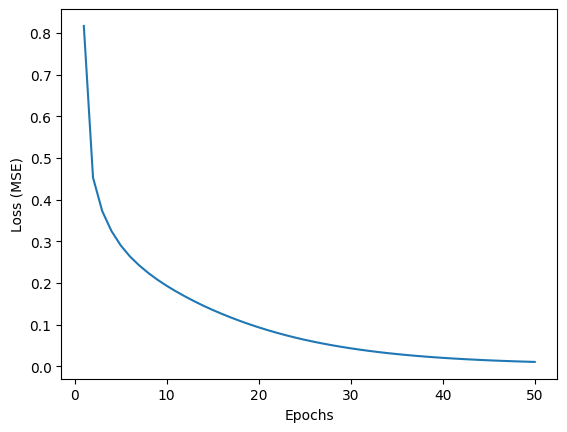

In [26]:
# TODO: Plot the loss over epochs
ep = torch.arange(num_epochs) +1
plt.figure()
plt.plot(ep, loss_all_epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.show()

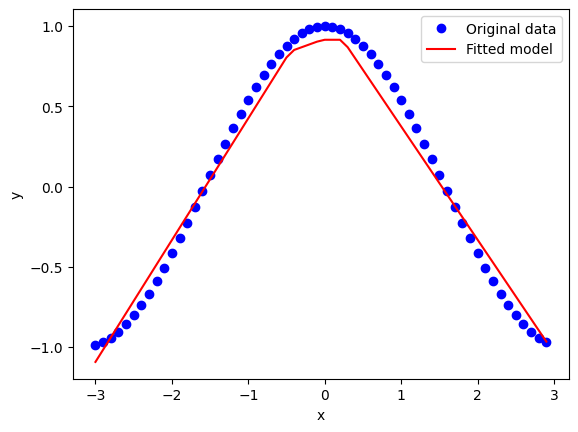

In [27]:
# TODO: Compute the predicted outputs, and plot the results (original data and predictions)
y_pred = nonlin_reg_model(x).detach()
plt.figure()
plt.plot(x, y, 'bo', label='Original data')
plt.plot(x, y_pred, 'r', label='Fitted model')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

# 4. More advanced example: Classification with MNIST
## 4.1. Dataset
We will use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, which is a large image dataset of hand-written digits.

<center><a href="https://en.wikipedia.org/wiki/MNIST_database">
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"></a></center>

Just like some other widely-used datasets, MNIST can be downloaded directly from Pytorch, and includes specific commands to create a `Dataset` object, a convenient data structure to manipulate datasets in Pytorch.

In [28]:
# We need the following libraries to download MNIST, create data and copy models.
import torchvision
from torch.utils.data import DataLoader, random_split, Subset
import copy

#TODO: If this cell triggers an error, install the necessary libraries in your environement

In [29]:
# Define the data repository
data_dir = 'data/'

# Choose one (or several) transform(s) to preprocess the data
# Here, we transform it to torch tensors, and we normalize the data (to zero-mean and unit-variance)
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# Create a Dataset (you can download the data by setting 'download=True')
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)

num_classes = len(train_data.classes)

# We take a subset of 2000 image samples to form the training data:
train_data = Subset(train_data, torch.arange(2000))

print('Number of classes in the dataset:', num_classes)
print('Number of images in the train dataset', len(train_data))

Number of classes in the dataset: 10
Number of images in the train dataset 2000


torch.Size([1, 28, 28])
Image label = 5


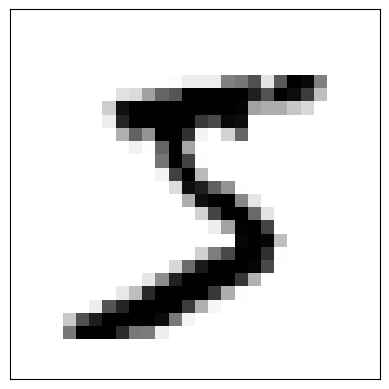

In [30]:
# Fetch one data pair (one image and the corresponding label)
image, label = train_data[0]
print(image.shape)
print('Image label =', label)

# You should note that the size of the image is [1, 28, 28], which corresponds to [num_channels, height, width]
# Indeed, MNIST images are in black and white so there is only 1 color channel.
# To plot this image, we need to remove this channel dimension by using squeeze()

plt.figure()
plt.imshow(image.squeeze(), cmap='gray_r')
plt.xticks([]), plt.yticks([])
plt.show()

## 4.2. Dataloader

A `Dataset` object stores all the data, and it might be very large. In practice, when using deep neural networks, we want to divide it into small packs (or *minibatches*) of data, in order to feed the network and compute stochatstic gradient descent. To that end, we create a `Dataloader`: it's a python class which samples over the dataset (that's the *batch sampler*) and assembles the data and labels (using a *collate function*) to generate batches.

&nbsp;

<center><a href="https://twitter.com/i/status/1363494433715552259">
    <img src="https://pbs.twimg.com/ext_tw_video_thumb/1363493414361305099/pu/img/x_qwSxBU2l0o5Y2z.jpg" width="500"></a>
</center>
<center>
(click on the image above to check the animation)
</center>

The good news is that there's a Pytorch function that does it automatically, so we don't need to bother with coding the batch sampler nor the collate function.

In [31]:
# Set the batch size (=number of samples/images in each batch) and create the dataloader with random batching
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

print('Number of batches in the training set: ', len(train_dataloader))

Number of batches in the training set:  250


In [32]:
# Get a batch of images and corresponding labels from the train dataloader
batch_example = next(iter(train_dataloader)) # We create an iterator from the dataloader, and get the first item from the iterator
image_batch_example = batch_example[0]  # NOTE: - the first element of the obtained torch tensor contains ALL images in the batch
labels_batch_example = batch_example[1] #       - the second element contains ALL corresponding labels

# Print the size of the batch of images and labels
print(image_batch_example.shape)
print(labels_batch_example.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8])


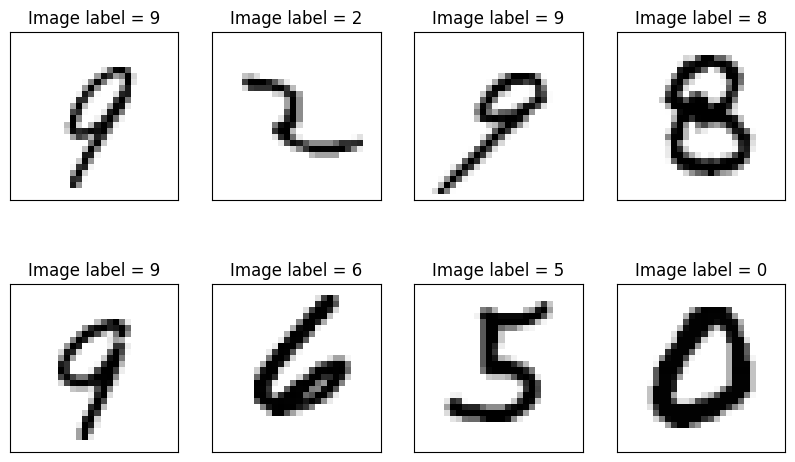

In [33]:
# Plot the images in the batch (along with the corresponding label)
plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

To feed the images to a multilayer perceptron in vector form, we will vectorize them as follows:

In [34]:
vectorized_batch = image_batch_example.reshape(image_batch_example.shape[0], -1)
print(vectorized_batch.shape)

torch.Size([8, 784])


## 4.3. General Multilayer Perceptron module

Now, let's create a general MLP classification network. It's a python class that inherits from the general `nn.Module` object, and it should contain at least 2 methods:

- `__init__`, which initializes the network when instanciated (creates all the layers and stores some useful parameters if needed).
- `forward`, which applies the forward pass (i.e., compute the output 'out' from the input, using the layers).

**Note**: Remember that Python classes usually define and use some variables/data/tensors/dictionary etc. internally (this includes network layers) called *attributes*: they should be defined in the `__init__` method with a specific structure (the name should start by `self.`). This allows us to access these attributes in other methods, or after instantiating an object of your class.

In [35]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers_hidden):
        super(MLPClassif, self).__init__()
        
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())
        self.num_layers_hidden = num_layers_hidden
        self.hidden_layers = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size,hidden_size), nn.ReLU()) for l in range(num_layers_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        y = self.input_layer(x)
        for l in range(self.num_layers_hidden):
            y = self.hidden_layers[l](y)
        y = self.output_layer(y)
        
        return y

**Question:** What do the different parameters of the initialization function correspond to?

In [36]:
# TODO: Instanciate an MLP classifier called model that takes vectorized MNIST images as input, with 3 hidden layers of size of 8 and 10 output classes.
input_size = vectorized_batch.shape[-1]
hidden_size = 8
output_size = num_classes
num_layers_hidden = 3

model = MLPClassif(input_size, hidden_size, output_size, num_layers_hidden)

**Note:** to call the `forward` method, we simply use model(x) where x is the input:

In [37]:
out = model(vectorized_batch)
print(out)

tensor([[-0.0243, -0.0972,  0.1975,  0.3130,  0.2740, -0.3543, -0.1140,  0.2252,
          0.0319, -0.4476],
        [-0.0205, -0.0937,  0.1924,  0.3174,  0.2741, -0.3687, -0.1173,  0.2387,
          0.0333, -0.4421],
        [-0.0307, -0.1051,  0.2001,  0.3118,  0.2795, -0.3451, -0.1182,  0.2167,
          0.0373, -0.4425],
        [-0.0280, -0.1055,  0.2049,  0.3084,  0.2800, -0.3251, -0.1149,  0.2093,
          0.0301, -0.4438],
        [-0.0204, -0.0879,  0.1936,  0.3127,  0.2684, -0.3806, -0.1123,  0.2409,
          0.0347, -0.4464],
        [-0.0276, -0.1079,  0.2091,  0.3058,  0.2812, -0.3060, -0.1126,  0.1999,
          0.0247, -0.4460],
        [-0.0254, -0.1051,  0.2025,  0.3123,  0.2799, -0.3232, -0.1150,  0.2108,
          0.0261, -0.4467],
        [-0.0305, -0.1057,  0.2077,  0.3039,  0.2801, -0.3264, -0.1144,  0.2074,
          0.0338, -0.4408]], grad_fn=<AddmmBackward0>)


Two important remarks can be made:

- The output `out` of the model has size `[batch_size, num_classes]` while the true labels `labels_batch_example` defined above has size `[batch_size]`. This is because the output `out` is meant to represent *predicted probabilities* for all classes, while `labels_batch_example` simply contains the true labels as integers.
- In classification tasks, we want to output _probabilities_ for all classes. However, nothing ensures that `out` corresponds to probabilities, since it is not normalized and we didn't use any output activation function (values can be negative and not sum up to 1).

However, when training a classification network, we generally use the [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) loss function, which solves both problems at once. This loss is implemented to handle integer-valued labels. Besides, it automatically applies a [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) non-linearity to the predicted outputs, which normalizes them as probabilies.

In [38]:
# Choose Cross Entropy as loss function
loss_fn = nn.CrossEntropyLoss()

# Compute the error between the predicted labels 'out' and true labels 'labels_batch_example'
loss_batch = loss_fn(out, labels_batch_example)
print(loss_batch.item())

2.530158281326294


## 4.4. General Training Loop
Below is an example of how a typical training function is defined in Pytorch.

**Questions:**
- What do the input and output variables of this function correspond to? 
- Which line of code predicts image labels given a batch of images?
- Which line of code is responsible to update the network's parameters?

In [39]:
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list for storing the training loss over epochs
    train_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        
        # Initialize the training loss for the current epoch
        tr_loss = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # Prepare the inputs and labels
            images = images.reshape(images.shape[0], -1)
            
            # Forward pass
            labels_predicted = model_tr(images)
            loss = loss_fn(labels_predicted, labels)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the current epoch loss
            # Note that 'loss.item()' is the loss averaged over the batch, so multiply it with the current batch size to get the total batch loss
            tr_loss += loss.item() * images.shape[0]

        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)
        
        # Display the training loss
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, tr_loss))
    
    return model_tr, train_losses

Epoch [1/30], Training loss: 2.3086
Epoch [2/30], Training loss: 2.2227
Epoch [3/30], Training loss: 2.0015
Epoch [4/30], Training loss: 1.7351
Epoch [5/30], Training loss: 1.4808
Epoch [6/30], Training loss: 1.2347
Epoch [7/30], Training loss: 1.0180
Epoch [8/30], Training loss: 0.8546
Epoch [9/30], Training loss: 0.7549
Epoch [10/30], Training loss: 0.6674
Epoch [11/30], Training loss: 0.5938
Epoch [12/30], Training loss: 0.5212
Epoch [13/30], Training loss: 0.4619
Epoch [14/30], Training loss: 0.4509
Epoch [15/30], Training loss: 0.4009
Epoch [16/30], Training loss: 0.3719
Epoch [17/30], Training loss: 0.3365
Epoch [18/30], Training loss: 0.3427
Epoch [19/30], Training loss: 0.3183
Epoch [20/30], Training loss: 0.2853
Epoch [21/30], Training loss: 0.2663
Epoch [22/30], Training loss: 0.2655
Epoch [23/30], Training loss: 0.2399
Epoch [24/30], Training loss: 0.2569
Epoch [25/30], Training loss: 0.2342
Epoch [26/30], Training loss: 0.2215
Epoch [27/30], Training loss: 0.2110
Epoch [28/

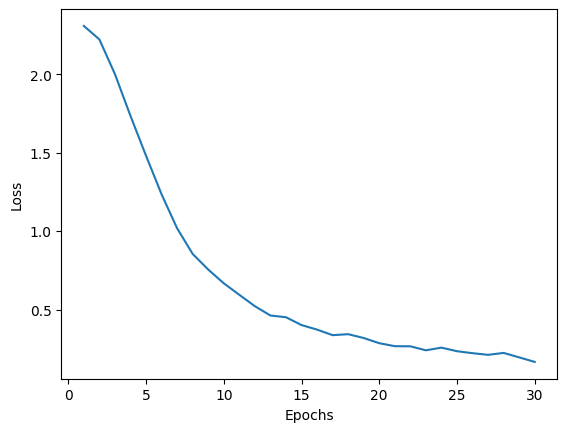

In [40]:
# TODO: use the function defined above to train the classification model on the MNIST training set
# Training parameters:
# - 30 epochs
# - learning rate = 0.01
# - loss function: Cross Entropy
# Display the loss over epochs using matplotlib

num_epochs = 30
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()

model_tr, train_losses = training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate)

plt.figure()
plt.plot(torch.arange(num_epochs)+1, train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 4.5. Evaluation

Now that the model is trained, we can evaluate it on the test dataset. We do that by predicting the labels using our model, and comparing it with the true labels. This allows us to compute the classification accuracy, which is provided in the function below.

In [41]:
# Evaluation function: similar to the training loop, except we don't need to compute any gradient / backprop

def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [42]:
# TODO:
# - Create a test dataloader from the test_data database object downloaded above.
# - Evaluate the trained model on the test set using the above function and print the accuracy

test_dataloader = DataLoader(test_data, batch_size=batch_size)

accuracy = eval_mlp_classifier(model_tr, test_dataloader)
print('Accuracy of the network on the test images:', accuracy, '%')

Accuracy of the network on the test images: 81.77 %


## 4.6. Bonus: use a larger model
As a last exercice, train now a larger model with 5 hidden layers of size 10, with the same learning rate and number of epochs. Display the loss over epochs, and print the accuracy of the model over the test set. **What do you observe and why?**

Epoch [1/30], Training loss: 2.3076
Epoch [2/30], Training loss: 2.3030
Epoch [3/30], Training loss: 2.3004
Epoch [4/30], Training loss: 2.2985
Epoch [5/30], Training loss: 2.2963
Epoch [6/30], Training loss: 2.2926
Epoch [7/30], Training loss: 2.2832
Epoch [8/30], Training loss: 2.2588
Epoch [9/30], Training loss: 2.1654
Epoch [10/30], Training loss: 1.9153
Epoch [11/30], Training loss: 1.6619
Epoch [12/30], Training loss: 1.4915
Epoch [13/30], Training loss: 1.3659
Epoch [14/30], Training loss: 1.2810
Epoch [15/30], Training loss: 1.1906
Epoch [16/30], Training loss: 1.0755
Epoch [17/30], Training loss: 1.0180
Epoch [18/30], Training loss: 0.9333
Epoch [19/30], Training loss: 0.8852
Epoch [20/30], Training loss: 0.8339
Epoch [21/30], Training loss: 0.7715
Epoch [22/30], Training loss: 0.7309
Epoch [23/30], Training loss: 0.6922
Epoch [24/30], Training loss: 0.6538
Epoch [25/30], Training loss: 0.6638
Epoch [26/30], Training loss: 0.6382
Epoch [27/30], Training loss: 0.5778
Epoch [28/

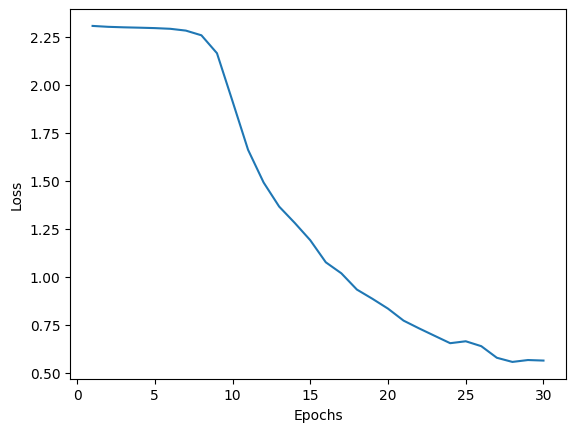

Accuracy of the big network on the test images: 72.05 %


In [43]:
# TODO
input_size = vectorized_batch.shape[-1]
hidden_size = 10
output_size = num_classes
num_layers_hidden = 5

model_big = MLPClassif(input_size, hidden_size, output_size, num_layers_hidden)

model_big_tr, train_losses = training_mlp_classifier(model_big, train_dataloader, num_epochs, loss_fn, learning_rate)

plt.figure()
plt.plot(torch.arange(num_epochs)+1, train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

accuracy = eval_mlp_classifier(model_big_tr, test_dataloader)
print('Accuracy of the big network on the test images:', accuracy, '%')